<h1> ______________________________________ </h1>

<h1> Time and Energy resolution calculation </h1>
<h1> ______________________________________ </h1>

<p style="font-size: 17px; color: black;"> In this Notebook we calculate the energy and time resolution of our photosensor (SiPM Hamamatsu in this case) the following way:</p>


- <p style="font-size: 17px; color: black; font-weight: bold;"> Energy resolution: </p> 
<p style="font-size: 17px; color: black;"> We save for each waveform the integral, then we do the distribution of that value and fit the peak by a gaussian. The sigma over mean value of that integral distribution will be our energy resolution.We won't be separating waveforms corresponding to 1pe, 2pe, 3pe, etc. this time.  </p> 


<h1> ____________ </h1>
<h2> This version </h2>
<h1> ____________ </h1>

-  <p style="font-size: 17px; color: black;"> In this notebook we don't save all the waveforms, but rather work with them re-reading the files. This might take more time but less memory, preventing the laptop to collapse. </p>
-  <p style="font-size: 17px; color: black;"> 10K events. </p>
-  <p style="font-size: 17px; color: black;"> Let's try and work with ALL events. </p>
-  <p style="font-size: 17px; color: black;"> Waveforms include just 1 peak. </p>



-  <p style="font-size: 17px; color: black;"> Calculate chi2. </p>



In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
import math

In [3]:
import scipy
from scipy import stats, integrate
from scipy.signal import find_peaks
from scipy.interpolate import interp1d
from scipy.optimize import root, root_scalar

In [4]:
import os

<h1> _________________________________________________________________________________________________________ </h1>


<h1> __________________________ </h1>
<h2> Functions </h2>

-  <p style="font-size: 17px; color: black;"> <b> gauss(x, a,  mu, sigma): </b> Gaussian normalized to $a$. </p>


-  <p style="font-size: 17px; color: black;"> <b> f_cut(x, f, val): </b> To find the cut of a $f(x)$ function with a certain value $val$ we first use <b> f_cut </b> to move $f(x) \rightarrow f(x) - val$ and then find it's roots, ie, $f(x) - val = 0$. </p>


-  <p style="font-size: 17px; color: black;"> <b> resolution_eq(E, a, b, c): </b> Resolution equation to which our results should fit. </p>



In [5]:
# Gaussian
# note: pdf are normilized to 1 so we have yo add an amplitude param
def gauss(x, a,  mu, sigma):
# def gauss(x,  mu, sigma):
    
    gaussian = stats.norm.pdf(np.sort(x), mu, sigma) 
    
    return (a/gaussian.sum())*gaussian 
#     return (x.sum()/gaussian.sum())*gaussian 

# Function offsetting
# To find the cut of a function with a certain value first we offset the function then find the roots
def f_cut(x, f, val):
    return f(x) - val

# Resolution equation
def resolution_eq(E, a, b, c):
    
    res = np.sqrt( (a/np.sqrt(E))**2 + (b/E)**2 + c**2)
    
    return res


-  <p style="font-size: 17px; color: black;"> <b> wave_prep(file): </b> Take a waveform and prepare it to work with it by separating the different variables, correcting offset and possible signal saturation. </p>



In [82]:
def wave_prep(file_name, path, waveform_saturation = np.inf):
    
    input_file = os.path.join(path, file_name)
    
    # Read the CSV file using pandas
    df = pd.read_csv(input_file, header=14)
    
    time = np.array(df['TIME']*1e6) # [us]
    signal = np.array(df['CH1']*1e3) # [mV]

    # Offsets
    if signal.min() < 0.:
        offset_signal = signal[signal < 0].mean(); signal = signal - offset_signal
    
    
    # Saturation
    signal = np.where(signal < waveform_saturation,               # where this condition applies...
                      signal,                                     # ... we use this value, and where NOT...
                      signal[signal < waveform_saturation].max()) # ... we use this other value
    
    return time, signal

<h1> __________________________ </h1>
<h2> Data </h2>

-  <p style="font-size: 17px; color: black;"> <b> Reading the file </b> </p>

-  <p style="font-size: 17px; color: black;"> File's path </p>

In [57]:
# filename = []
path = {}

init_path = '/home/investigator/mariandbt/python/data/'

path = init_path + '20230718_co57/'

-  <p style="font-size: 17px; color: black;"> Parameters to read the file. </p>

In [58]:
# Get all files in the folder
files = os.listdir(path)

-  <p style="font-size: 17px; color: black;"> Parameters of the read file. </p>

In [11]:
n_frames = int(len(files))
n_points = int(6250)

print('n_points = ', n_points)
print('n_frames = ', n_frames)

n_points =  6250
n_frames =  15000


<h1> __________________________ </h1>
<h2> Global parameters </h2>

-  <p style="font-size: 17px; color: black;"> <b> Analysis parameters </b> </p>

 -  <p style="font-size: 17px; color: black;"> <b> patata: </b> Patata. </p>
 
 


<h1> __________________________ </h1>
<h2> Analysis </h2>

<h2> Waveform </h2>

-  <p style="font-size: 17px; color: black;"> Interpolate the waveform to create a function. </p>

In [83]:
frame = 0

-  <p style="font-size: 17px; color: black;"> Time region where to look for signal. </p>

In [84]:
tt_min = -0.1 # [us]
tt_max = 0.25 # [us]


In [85]:
tt_region_mask = (tt > tt_min) & (tt < tt_max) # Where to look for the signal
    

<p style="font-size: 17px; color: black;"> Data waveform

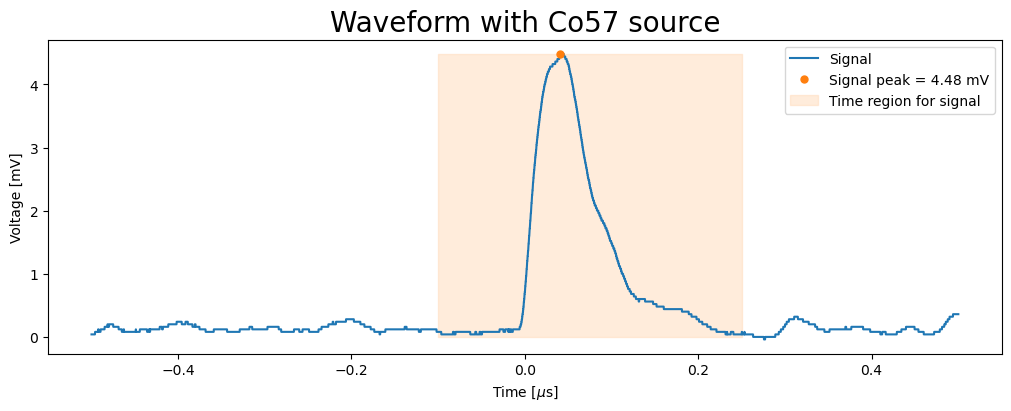

In [86]:
fig, ax = plt.subplots(1, 1, figsize = (10, 4), constrained_layout=True)

ax.plot(tt, ss, label = 'Signal')
ax.plot(tt[ss == ss.max()][0], ss.max(), 'o', markersize = 5, 
           label = 'Signal peak = %.2f mV'%(ss.max()))

ax.fill_between([tt_min, tt_max], ss.max(), 
                color = 'peachpuff', alpha = 0.5, label = r'Time region for signal') 

ax.set_ylabel('Voltage [mV]');
ax.set_xlabel(r'Time [$\mu$s]');
ax.set_title('Waveform with Co57 source', size = 20);
ax.legend(loc = 'best')

<h2> Integral calculation for all frames </h2>

- <p style="font-size: 17px; color: black;"> Note how we're working with the fact that the signal appears in a certain time region to constrain the valid region of signal we use using the mask.

In [87]:
charge = []


try:
    for frame in range(n_frames):

        file_name = files[frame]

        tt, ss = wave_prep(file_name, path, waveform_saturation = np.inf)


        tt_region_mask = (tt > tt_min) & (tt < tt_max) # Where to look for the signal

        th = 0. # [mV]

        if ss[tt_region_mask].max() < th: 
            print('NO SIGNAL HERE! frame = %s; th = %.2f # [mV]'%(frame, th))
            continue

        # Integrate withini the time region
        integr = np.trapz(ss[tt_region_mask], x = tt[tt_region_mask])

        charge.append(integr)

except Exception as e:
    print("Python sais:", str(e))
    print("Marian sais: Error accured in frame %s"%(frame))

charge = np.array(charge)
    

<h2> Energy resolution calculation </h2>

9720.0 9653.923707331529 9653.923707331527


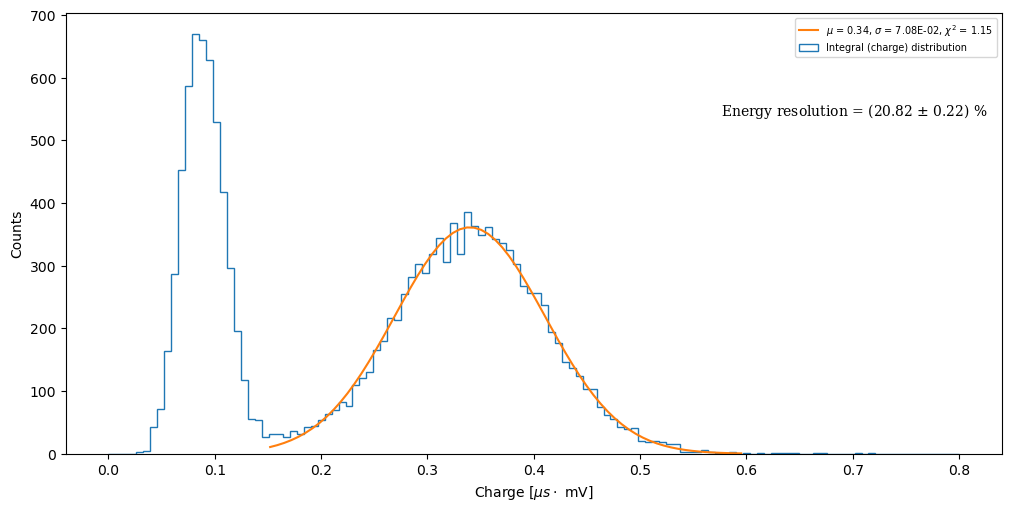

In [115]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5), constrained_layout=True)

    
N_ev = len(charge)
#     n_bins = 5*int(np.sqrt(N_ev))
n_bins = int(np.sqrt(N_ev))

events, bins, bars = ax.hist(charge, n_bins, 
                             density=False,
                             range=(0., 0.8),
                             label='Integral (charge) distribution', 
                             histtype='step')
x_ax = np.linspace(bins.min(), bins.max(), len(bins)-1)

x_ax_mask = (x_ax > 0.15) & (x_ax < 0.6)
x_ax = x_ax[x_ax_mask]
events = events[x_ax_mask]


#     # gaussian fit
popt, pcov = scipy.optimize.curve_fit(gauss, x_ax, events, p0=[1, 0.35, 0.2]) 
# popt, pcov = scipy.optimize.curve_fit(gauss, x_ax, events, 
#                                       sigma = np.where(events > 0., np.sqrt(events), 1e-3),
#                                       bounds=([events.sum(),  0.9*bins.mean(), 10.], [np.inf, bins.mean(), 60.])) 

best_fit_line = gauss(x_ax, *popt)
a, mu, sigma = popt

print(events.sum(), best_fit_line.sum(), a)

param_err = np.sqrt(np.diag(pcov))
a_err, mu_err, sigma_err = param_err

# # Calculate the residuals and chi-square
# residuals = events - gauss(x_ax, *popt)
# data_err = np.sqrt(events)

# chi2 = np.sum(np.where(data_err > 0., (residuals/ data_err)**2, 0.))
# chi2 /= len(bins) # /dof

# Calculate p-value and chi-square
fit_norm = best_fit_line*events.sum()/best_fit_line.sum() # need to normalize the fit 
chi2, p_value = stats.chisquare(f_obs = events, f_exp = fit_norm, axis = None)
# chi2, p_value = stats.chisquare(f_obs = events, f_exp = best_fit_line, axis = None)
chi2 /= len(bins) # /dof

e_res = 100*sigma/mu # %
e_res_err = 100*np.sqrt( (sigma_err/mu)**2 + (sigma*mu_err/mu**2)**2 )

#_________plot_settings_________________________________________________

ax.plot(x_ax, best_fit_line, '-', 
        label='$\mu$ = %.2f, $\sigma$ = %.2E, $\chi^{2}$ = %.2f'%(mu, sigma, chi2))

ax.text(0.7, .8, r'Energy resolution = (%.2f $\pm$ %.2f) %%'%(e_res, e_res_err), transform=ax.transAxes,
        fontsize=10, verticalalignment='top', fontfamily='serif',
        bbox=dict(facecolor='1.', edgecolor='none', pad=3.0))

ax.set_ylabel('Counts')
ax.set_xlabel(r'Charge [$\mu s\cdot$ mV]')

ax.legend(fontsize=7, loc='best')
        